In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__version__ = '1.0.0'

import matplotlib.pyplot as plt
from models.dnn import NeuralNet
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from trustscore import TrustScore
from utils import plot_precision_curve
from utils import run_model
from utils import run_precision_plt
assert tf.__version__.startswith('2')

In [2]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0], True
)

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
BATCH_SIZE = 512
EPOCHS = 60

In [5]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.mnist.load_data()

train_features = train_features.reshape(-1, 784)
train_features = train_features.astype('float32')
train_features = train_features / 255.

test_features = test_features.reshape(-1, 784)
test_features = test_features.astype('float32')
test_features = test_features / 255.

train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [6]:
validation_features, test_features, validation_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.50, stratify=test_labels)

In [7]:
pca = PCA(n_components=64)
enc_train_features = pca.fit_transform(train_features)
enc_test_features = pca.transform(test_features)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
train_dataset = train_dataset.prefetch(BATCH_SIZE * 8)
train_dataset = train_dataset.shuffle(train_features.shape[0])
train_dataset = train_dataset.batch(BATCH_SIZE, True)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_features, validation_labels))
validation_dataset = validation_dataset.batch((BATCH_SIZE // 4))

test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
test_dataset = test_dataset.batch((BATCH_SIZE // 4))

W0827 21:23:22.186218 139812022417216 deprecation.py:323] From /home/darth/tf2/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
model = NeuralNet(input_shape=(784,),
                  units=[512, 512],
                  dropout_rate=2e-1,
                  num_classes=10)

In [10]:
model.compile(loss=tf.losses.categorical_crossentropy,
              optimizer=tf.optimizers.SGD(learning_rate=1e-1, decay=1e-6, momentum=9e-1),
              metrics=['accuracy'])

In [11]:
model(train_features[0].reshape(1, 784))

<tf.Tensor: id=190, shape=(1, 10), dtype=float32, numpy=
array([[0.1333855 , 0.07496793, 0.09126589, 0.13227628, 0.08643716,
        0.09886126, 0.11466784, 0.07162109, 0.07591826, 0.12059879]],
      dtype=float32)>

In [12]:
model.summary()

Model: "neural_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  401920    
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  262656    
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(train_dataset,
                    epochs=60,
                    validation_data=validation_dataset,
                    verbose=2)

Epoch 1/60
117/117 - 2s - loss: 0.4037 - accuracy: 0.7809 - val_loss: 0.1686 - val_accuracy: 0.9476
Epoch 2/60
117/117 - 1s - loss: 0.1323 - accuracy: 0.9554 - val_loss: 0.1050 - val_accuracy: 0.9686
Epoch 3/60
117/117 - 1s - loss: 0.0906 - accuracy: 0.9708 - val_loss: 0.0851 - val_accuracy: 0.9738
Epoch 4/60
117/117 - 1s - loss: 0.0673 - accuracy: 0.9796 - val_loss: 0.0777 - val_accuracy: 0.9768
Epoch 5/60
117/117 - 1s - loss: 0.0538 - accuracy: 0.9835 - val_loss: 0.0790 - val_accuracy: 0.9750
Epoch 6/60
117/117 - 1s - loss: 0.0437 - accuracy: 0.9871 - val_loss: 0.0780 - val_accuracy: 0.9756
Epoch 7/60
117/117 - 1s - loss: 0.0338 - accuracy: 0.9908 - val_loss: 0.0729 - val_accuracy: 0.9786
Epoch 8/60
117/117 - 1s - loss: 0.0271 - accuracy: 0.9933 - val_loss: 0.0683 - val_accuracy: 0.9796
Epoch 9/60
117/117 - 1s - loss: 0.0222 - accuracy: 0.9947 - val_loss: 0.0669 - val_accuracy: 0.9790
Epoch 10/60
117/117 - 1s - loss: 0.0187 - accuracy: 0.9951 - val_loss: 0.0671 - val_accuracy: 0.9804

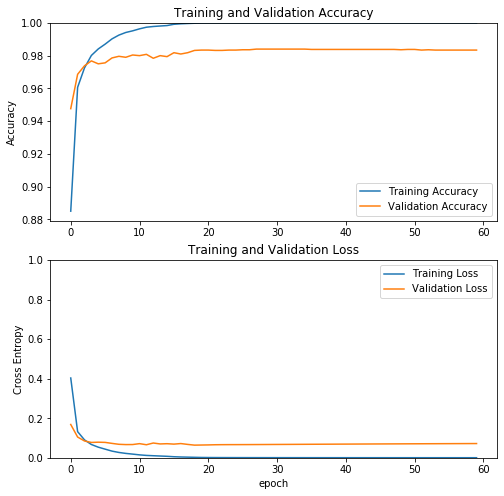

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [15]:
score = model.evaluate(test_dataset)
print('test accuracy : {}'.format(score[1]))

40/40 [==============================] - 0s 4ms/step - loss: 0.0727 - accuracy: 0.9820
test accuracy : 0.9819999933242798


In [16]:
ts = TrustScore(alpha=5e-2)
ts.fit(enc_train_features, train_labels)

In [17]:
predictions = model.predict(test_features)

In [18]:
trust_scores, closest_classes = ts.score(enc_test_features,
                                         predictions,
                                         k=5)

In [19]:
num_samples = 5
index_min = np.argsort(trust_scores)[:num_samples]
index_max = np.argsort(trust_scores)[-num_samples:]
score_min = trust_scores[index_min]
score_max = trust_scores[index_max]
closest_min = closest_classes[index_min]
closest_max = closest_classes[index_max]
prediction_min = tf.argmax(predictions[index_min], 1)
prediction_max = tf.argmax(predictions[index_max], 1)
likelihood_min = tf.math.reduce_max(predictions[index_min], 1)
likelihood_max = tf.math.reduce_max(predictions[index_max], 1)
label_min = tf.argmax(test_labels[index_min], 1)
label_max = tf.argmax(test_labels[index_max], 1)
features_min = test_features[index_min]
features_max = test_features[index_max]

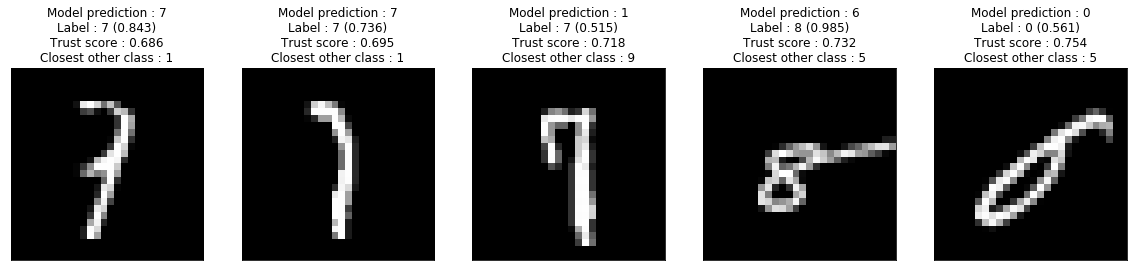

In [20]:
plt.figure(figsize=(20, 4))

for index in range(num_samples):
    axis = plt.subplot(1, num_samples, index + 1)
    plt.imshow(features_min[index].reshape(28, 28), cmap='gray')
    plt.title('Model prediction : {}\nLabel : {} ({:.3f})\nTrust score : {:.3f}' \
              '\nClosest other class : {}'.format(prediction_min.numpy()[index],
                                                  label_min.numpy()[index],
                                                  likelihood_min[index],
                                                  score_min[index],
                                                  closest_min[index]))
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
plt.show()

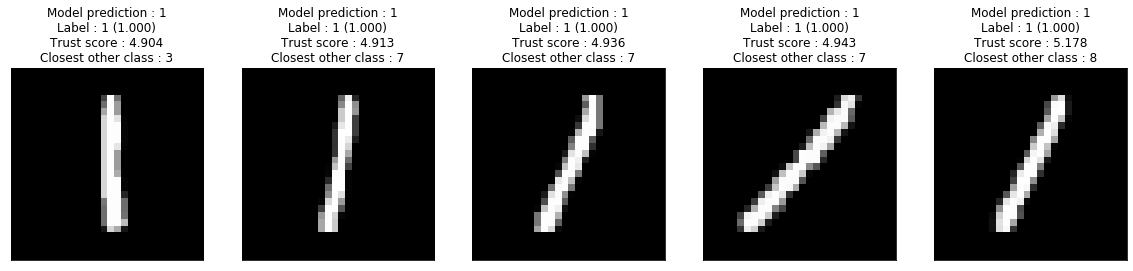

In [21]:
plt.figure(figsize=(20, 4))

for index in range(num_samples):
    axis = plt.subplot(1, num_samples, index + 1)
    plt.imshow(features_max[index].reshape(28, 28), cmap='gray')
    plt.title('Model prediction : {}\nLabel : {} ({:.3f})\nTrust score : {:.3f}' \
              '\nClosest other class : {}'.format(prediction_max.numpy()[index],
                                                  label_max.numpy()[index],
                                                  likelihood_max[index],
                                                  score_max[index],
                                                  closest_max[index]))
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
plt.show()

In [22]:
percentiles = [0 + 0.5 * index for index in range(200)]
num_fold = 5
plt_names = ['Model Confidence', 'Trust Score']

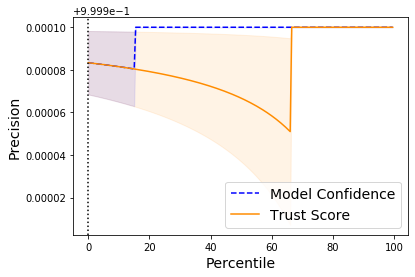

In [25]:
run_precision_plt(train_features,
                  train_labels,
                  num_fold,
                  percentiles,
                  run_model,
                  plt_title='',
                  plt_names=plt_names,
                  predict_correct=True,
                  model=model)

In [24]:
model.save_weights('saved_model/mnist/dnn/1', save_format='tf')